In [14]:
#!pip install pyDOE
#!pip install torch
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install tqdm

In [15]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import time, sys
from tqdm.notebook import tqdm_notebook

from pyDOE import lhs

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("The neural network will be trainied on",device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

The neural network will be trainied on cuda


In [16]:
def plot3D(x,t,y):
    x_plot =x.squeeze(1).cpu().numpy()
    t_plot =t.squeeze(1).cpu().numpy()
    X,T= np.meshgrid(x_plot,t_plot,indexing='ij')
    u_xt = y.cpu().numpy()
    fig = plt.figure()
    ax=fig.subplots(1,1)
    cp = ax.contourf(T,X,u_xt,20,cmap=cm.rainbow) #)levels = np.linspace(-1.0,1.0,12))
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(T, X, u_xt,cmap=cm.rainbow, antialiased=False)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    #ax.set_zlim3d(-1, 1)
    plt.show()

In [17]:
#x∈[-1,1] przedział dla równania falowego
x_min=-1
x_max=1

#t∈[0,0.48]
t_min=0
t_max=3

#Discretization points for x and t

total_points_x=1001
total_points_t=1000

dx = (x_max-x_min)/(total_points_x-1)

dt = (t_max-t_min)/(total_points_t)


dx,dt, dt/dt


(0.002, 0.003, 1.0)

In [18]:
#Implementing Finite Difference Method to solve the 1D wave equanation

def u_fem(x, t, c_val):
    # Convert scalar parameters to tensors and move to the device of x
    c = torch.tensor(c_val, dtype=torch.float32, device=x.device)
    dt_tensor = torch.tensor(dt, dtype=torch.float32, device=x.device)
    dx_tensor = torch.tensor(dx, dtype=torch.float32, device=x.device)

    u_prev = torch.zeros(total_points_x, 1, device=x.device)
    u_current = torch.sin(torch.pi * x)  # Use torch.pi for consistency
    u_next = torch.zeros(total_points_x, 1, device=x.device)

    rec = torch.zeros([total_points_x, total_points_t], device=x.device)

    # Z warunku na u_t(x,0)=0
    # Use tensor versions of dt, dx, c
    # The term 0 * dt_tensor ensures it's a tensor and on device, but effectively still 0.
    coeff_init = 0.5 * (c * dt_tensor / dx_tensor)**2
    u_next[1:-1] = u_current[1:-1] + coeff_init * (u_current[2:] - 2*u_current[1:-1] + u_current[:-2])

    for j in range(1, total_points_t):
        rec[:, j-1] = u_current.squeeze(1)

        u_prev, u_current = u_current, u_next.clone()

        # Update u_next using the wave equation finite difference scheme
        coeff_iter = (c * dt_tensor / dx_tensor)**2
        u_next[1:-1] = (2*u_current[1:-1] - u_prev[1:-1] +
                        coeff_iter * (u_current[2:] - 2*u_current[1:-1] + u_current[:-2]))

        # Warunki brzegowe Dirichleta u(0,1)=0, u(1,t)=0
        u_next[0, 0] = 0
        u_next[-1, 0] = 0

    return u_next, rec

In [19]:
x = torch.linspace(x_min, x_max, total_points_x)
u = torch.from_numpy(np.sin(np.pi*x.numpy()))

In [20]:
u_plot = u.clone()
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x, u_plot, lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Wave Equation at t=0');


In [21]:
# Creating same amount of grid lattice as FDM

x = torch.linspace(x_min, x_max, total_points_x).view(-1,1).to(device)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1).to(device)
x.shape, t.shape

(torch.Size([1001, 1]), torch.Size([1000, 1]))

In [22]:
# Computing Finite Difference solution for u

print("Running Finite Difference Method...")
u_final, u_fem_2D = u_fem(x, t, c_val=1.0) # Changed parameter name to c_val

assert u_fem_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_fem_2D.shape}"
print("Completed successfully!")

Running Finite Difference Method...
Completed successfully!


In [23]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij')


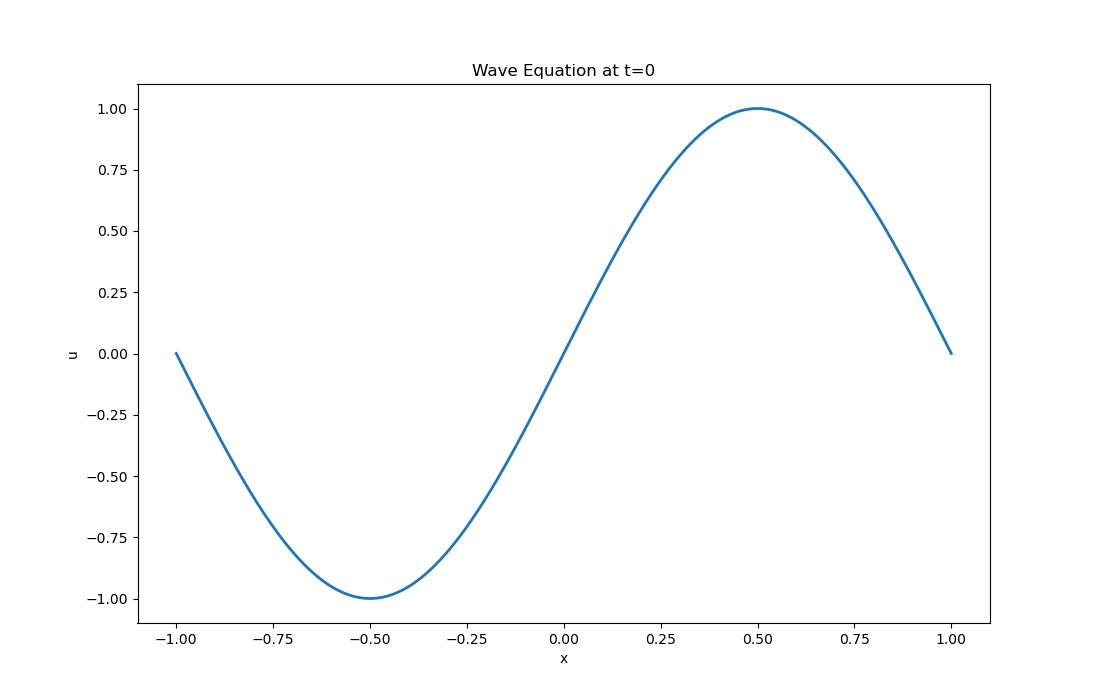

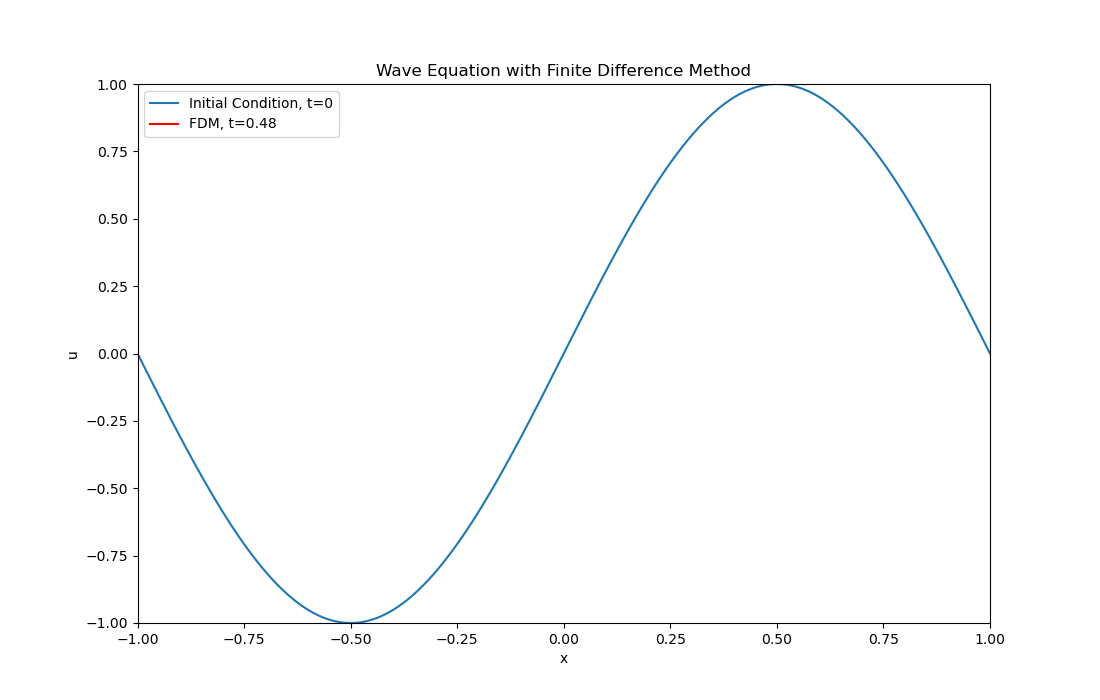

In [24]:
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x.cpu().numpy(), u_plot.cpu().numpy(), label="Initial Condition, t=0")
plt.plot(x.cpu().numpy(), u_final.cpu().numpy(), 'r',label="FDM, t=0.48")
plt.xlim([x_min,x_max])
plt.ylim([-1, 1])
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Wave Equation with Finite Difference Method');
plt.show()

FDM Solution Visualization


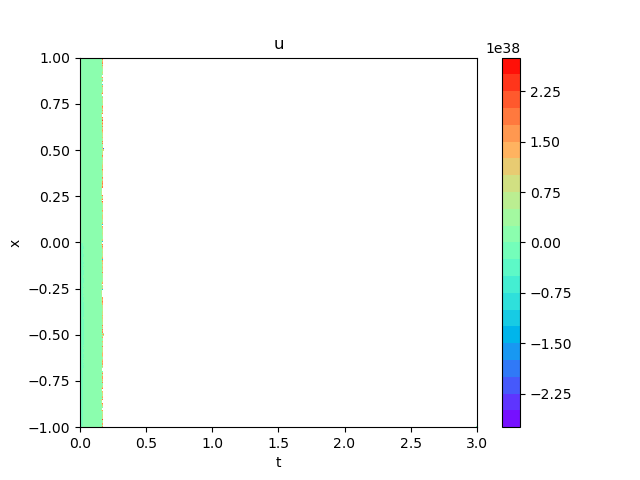

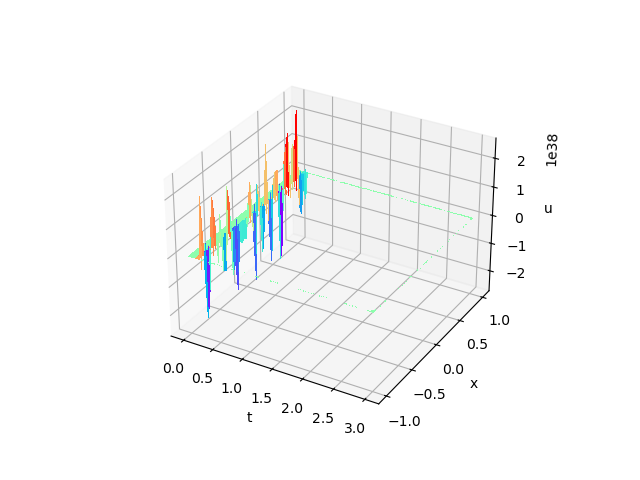

In [25]:
print("FDM Solution Visualization")
plot3D(x,t,u_fem_2D)


In [26]:
# Creating same amount of grid lattice as FDM
x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1)
x.shape, t.shape


(torch.Size([1001, 1]), torch.Size([1000, 1]))

In [27]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij') #same as FDM
X.shape, T.shape
left_X = torch.hstack((X[:,0][:,None], T[:,0][:,None])) #horizontal stacking to create X, T dataset
left_U = torch.sin(np.pi*left_X[:,0]).unsqueeze(1) #initial condition is a sine wave
left_U.shape

torch.Size([1001, 1])

In [28]:
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x, left_U, lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Wave Equation at t=0');


In [29]:
# BC at x_min
bottom_X = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))

bottom_U = torch.zeros(bottom_X.shape[0],1)
top_U = torch.zeros(top_X.shape[0],1)

bottom_X.shape


torch.Size([1000, 2])

In [30]:
X_bc = torch.vstack([bottom_X, top_X])
U_bc = torch.vstack([bottom_U, top_U])

X_bc.shape


torch.Size([2000, 2])

In [31]:
N_ic = 1000
N_bc = 1000 #Number of points on IC and BC
N_pde = 30000 #Number of points on PDE domain (Collocation Points)

#Now we will sample N_bc points at random
#from the X_train, U_train dataset

idx = np.random.choice(X_bc.shape[0],N_bc, replace=False)
X_bc_samples = X_bc[idx,:]
U_bc_samples = U_bc[idx,:]

idx = np.random.choice(left_X.shape[0],N_ic, replace=False)
X_ic_samples = left_X[idx,:]
U_ic_samples = left_U[idx,:]

#The boundary conditions will not change.
#Hence, these U values can be used as supervised labels during training

#For PDE collocation points, we will generate new X_train_pde dataset
#We do not know U(X,T) for these points

#Lets get the entire X,T dataset in a format suitable for Neural Network
#We will later use this for testing NN as well. So, lets call this x_test for convenience

x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],
                       T.transpose(1,0).flatten()[:,None]))

#We need column major flattening to simlulte time-marching. Hence the transpose(1,0) or simply use .T

#we will use U generated from FEM as our u_test
#We will use u_test later in the process for calculating NN performance

u_test = u_fem_2D.transpose(1,0).flatten()[:,None]
x_test.shape


torch.Size([1001000, 2])

In [32]:
x_test.shape


torch.Size([1001000, 2])

In [33]:
#lower and upper bounds of x_test
lb = x_test[0]
ub = x_test[-1]
lb,ub


(tensor([-1.,  0.]), tensor([1., 3.]))

In [34]:
#Sampling (X,T) domain using LHS
lhs_samples = lhs(2,N_pde)
#2 since there are 2 variables in X_train, [x,t]
lhs_samples.shape

(30000, 2)

In [35]:
X_train_lhs = lb + (ub-lb)*lhs_samples
X_train_lhs.shape


/tmp/ipykernel_1952/752805534.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_train_lhs = lb + (ub-lb)*lhs_samples


torch.Size([30000, 2])

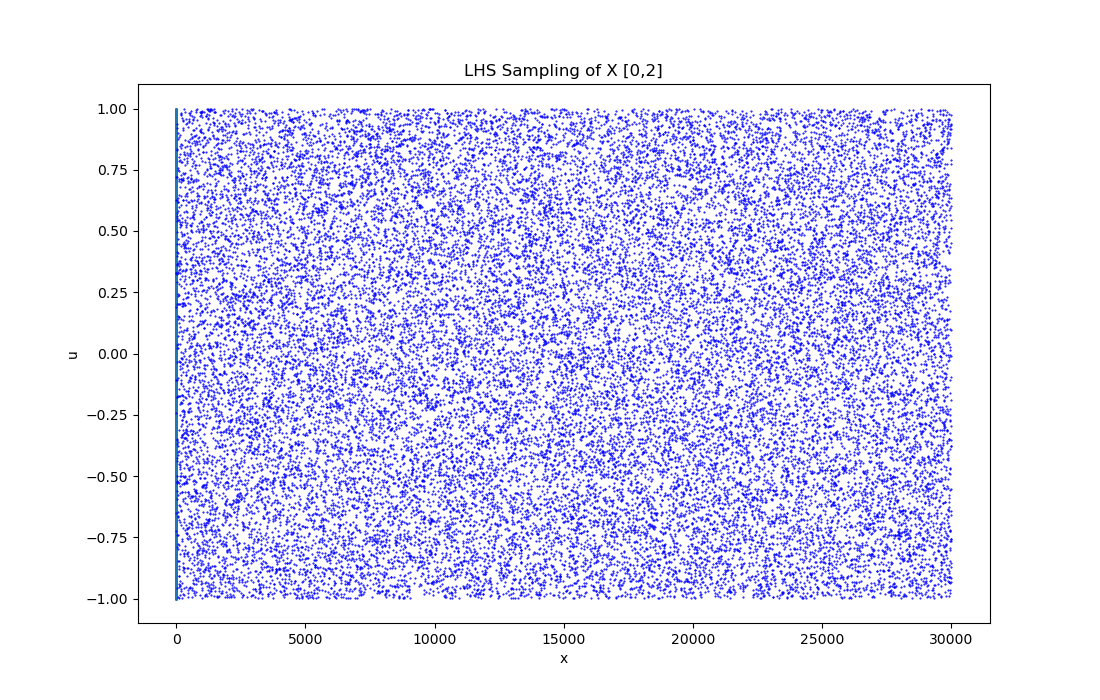

In [36]:
plt.plot(pd.DataFrame(X_train_lhs)[0], "bo", markersize=.5)
plt.title("LHS Sampling of X [0,2]")
plt.show()


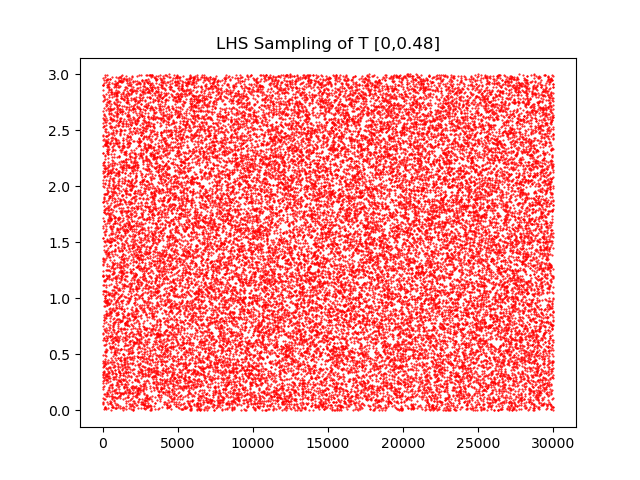

In [37]:
plt.plot(pd.DataFrame(X_train_lhs)[1], "ro", markersize=.5)
plt.title("LHS Sampling of T [0,0.48]")
plt.show()

In [38]:
X_train_final = torch.vstack((X_train_lhs, X_ic_samples, X_bc_samples))
X_train_final.shape

torch.Size([32000, 2])

In [39]:
#Lets define a u_NN

class u_NN(nn.Module):

    def __init__(self, layers_list):
        super().__init__()
        self.depth = len(layers_list)
        self.loss_function = nn.MSELoss(reduction="mean")
        self.activation = nn.Tanh() #This is important, ReLU wont work
        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])
        for i in range(self.depth-1):
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #xavier normalization of weights
          nn.init.zeros_(self.linears[i].bias.data) #all biases set to zero

    def Convert(self, x): #helper function

        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)

    def forward(self, x):
        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)
        return a

    def loss_bc(self, x_bc, u_bc):#This is similar to a Supervised Learning
        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(u_bc)) #L2 loss
        return l_bc

    def loss_ic(self, x_ic, u_ic): #This is similar to a Supervised Learning
        l_ic = self.loss_function(self.forward(self.Convert(x_ic)), self.Convert(u_ic)) #L2 loss
        return l_ic

    def loss_pde(self, x_pde):
        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone()
        x_pde_clone.requires_grad = True

        # u(x,t)
        NN = self.forward(x_pde_clone)

        # [u_x, u_t]
        grads = torch.autograd.grad( NN, x_pde_clone,
            self.Convert(torch.ones_like(NN)),
            retain_graph=True, create_graph=True )[0]

        u_x = grads[:, [0]]
        u_t = grads[:, [1]]

        # drugi rząd pochodnych: [u_xx, u_tt]
        grads2 = torch.autograd.grad( grads, x_pde_clone,
            self.Convert(torch.ones(grads.shape)), create_graph=True)[0]

        u_xx = grads2[:, [0]]
        u_tt = grads2[:, [1]]

        # równanie falowe u_tt - c^2 u_xx = 0
        c_wave = 1.0   # lub parametr
        residue = u_tt - (c_wave**2) * u_xx

        zeros = self.Convert(torch.zeros_like(residue))
        l_pde = self.loss_function(residue, zeros)

        return l_pde

    def loss_ic_dt(self, x_ic, u_ic_dt):
        x_ic = self.Convert(x_ic)
        x_ic_clone = x_ic.clone()
        x_ic_clone.requires_grad = True

        NN = self.forward(x_ic_clone)

        grads = torch.autograd.grad(
            NN, x_ic_clone,
            self.Convert(torch.ones_like(NN)),
            retain_graph=True,
            create_graph=True)[0]

        u_t  = grads[:, [1]]  # pochodna po t

        return self.loss_function(u_t , self.Convert(u_ic_dt))



    def total_loss(self, x_ic, u_ic, x_ic_dt, u_ic_dt, x_bc, u_bc, x_pde):
        l_bc = self.loss_bc(x_bc, u_bc)
        l_ic = self.loss_ic(x_ic, u_ic)
        l_ic_dt = self.loss_ic_dt(x_ic_dt, u_ic_dt)
        l_pde = self.loss_pde(x_pde)
        return l_bc + l_ic + l_ic_dt + l_pde #this HAS to be a scalar value for auto differentiation to do its thing.


In [40]:
#Parameters for u_NN

EPOCHS = 100000
initial_lr = 0.001
layers_list = [2, 32, 128, 64, 128, 32, 1]
#batch_size = 32

# Instantiate a model

PINN = u_NN(layers_list).to(device)
print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(), lr=initial_lr,amsgrad=False)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

history = pd.DataFrame(columns=["Epochs","Learning_Rate", "IC_Loss","BC_Loss","PDE_Loss","Total_Loss","Test_Loss"])


u_NN(
  (loss_function): MSELoss()
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [41]:
#****** Training ******#

print("Training Physics Informed Neural Network...")

Epoch = []
Learning_Rate = []
IC_Loss = []
BC_Loss = []
PDE_Loss = []
Total_Loss = []
Test_Loss = []

for i in tqdm_notebook(range(EPOCHS)):
    if i==0:
        print("Epoch \t Learning_Rate \t IC_Loss \t BC_Loss \t PDE_Loss \t Total_Loss \t Test_Loss")

    # Prepare u_ic_dt, which is 0 for the initial condition du/dt(x,0) = 0
    u_ic_dt_zeros = torch.zeros_like(U_ic_samples)

    l_ic = PINN.loss_ic(X_ic_samples,U_ic_samples)
    l_bc = PINN.loss_bc(X_bc_samples,U_bc_samples)
    l_pde = PINN.loss_pde(X_train_final)
    loss = PINN.total_loss(X_ic_samples, U_ic_samples, X_ic_samples, u_ic_dt_zeros, X_bc_samples, U_bc_samples, X_train_final)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if i%100 == 0: #print losses and step the exponential learning rate.

        with torch.no_grad():
            test_loss = PINN.loss_bc(x_test,u_test) #Here we are using loss_bc method as a helper function to calculate L2 loss

            Epoch.append(i)
            Learning_Rate.append(scheduler.get_last_lr()[0])
            IC_Loss.append(l_ic.detach().cpu().numpy())
            BC_Loss.append(l_bc.detach().cpu().numpy())
            PDE_Loss.append(l_pde.detach().cpu().numpy())
            Total_Loss.append(loss.detach().cpu().numpy())
            Test_Loss.append(test_loss.detach().cpu().numpy())

            if i%1000 ==0:
               print(i,'\t',format(scheduler.get_last_lr()[0],".4E"),'\t',format(l_ic.detach().cpu().numpy(),".4E"),'\t',format(l_bc.detach().cpu().numpy(),".4E"),'\t',
                  format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"),'\t',format(test_loss.detach().cpu().numpy(),".4E"))

        scheduler.step()

print("Completed!!")

Training Physics Informed Neural Network...


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 	 Learning_Rate 	 IC_Loss 	 BC_Loss 	 PDE_Loss 	 Total_Loss 	 Test_Loss


/home/mijki/anaconda3/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0 	 1.0000E-03 	 3.1805E-01 	 1.7367E-01 	 8.9871E-03 	 5.8909E-01 	 NAN
1000 	 8.5973E-04 	 1.0718E-02 	 4.3264E-02 	 4.0453E-03 	 5.9152E-02 	 NAN
2000 	 7.3914E-04 	 1.0376E-03 	 8.8745E-03 	 1.0063E-03 	 1.0964E-02 	 NAN
3000 	 6.3546E-04 	 4.8608E-04 	 4.2520E-03 	 4.3044E-04 	 5.2086E-03 	 NAN
4000 	 5.4632E-04 	 5.2977E-04 	 3.6463E-03 	 1.3189E-03 	 7.8190E-03 	 NAN
5000 	 4.6969E-04 	 3.7072E-05 	 1.5581E-04 	 1.6070E-04 	 3.9193E-04 	 NAN
6000 	 4.0381E-04 	 7.0022E-06 	 3.3420E-05 	 6.7521E-05 	 1.2497E-04 	 NAN
7000 	 3.4717E-04 	 1.3296E-04 	 6.5857E-05 	 2.1968E-04 	 4.7941E-04 	 NAN
8000 	 2.9847E-04 	 1.5185E-06 	 1.1000E-05 	 3.0771E-05 	 5.2810E-05 	 NAN
9000 	 2.5660E-04 	 4.8119E-06 	 2.2225E-05 	 1.2012E-04 	 1.8229E-04 	 NAN
10000 	 2.2061E-04 	 3.4166E-04 	 2.5915E-04 	 6.8670E-04 	 1.5201E-03 	 NAN
11000 	 1.8966E-04 	 1.1589E-06 	 6.9515E-06 	 1.8819E-05 	 3.2750E-05 	 NAN
12000 	 1.6306E-04 	 1.0553E-06 	 6.2796E-06 	 1.6715E-05 	 2.9102E-05 	 NAN
13000 	 1.40

In [55]:
u_NN_predict = PINN(x_test)


In [56]:
#Reshapping y1 to be used in plot3d()

u_NN_2D = u_NN_predict.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()

assert u_NN_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_NN_2D.shape}"


In [58]:
import os

os.makedirs("./Wave", exist_ok=True)
plt.savefig("./Wave/" + file_name_loss)


In [59]:
RMSE = torch.sqrt(torch.tensor(Test_Loss[-1], dtype=torch.float32)) # Calculate RMSE from the last test_loss

file_name_loss = "LOSS_CURVES_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".png"
fig, ax1 = plt.subplots(figsize=(11, 7), dpi= 100)
ax2 = ax1.twinx()
ax1.plot(Epoch, IC_Loss, "b-",label = "IC Loss")
ax1.plot(Epoch, BC_Loss, "g-",label = "BC Loss")
ax1.plot(Epoch, PDE_Loss, "c-",label = "PDE Loss")
ax1.plot(Epoch, Total_Loss, "k-",label = "Total Loss")
ax1.plot(Epoch, Test_Loss, "m-",label = "Test Loss")
ax2.plot(Epoch,Learning_Rate, "ro",markersize=1,label = "Learning Rate")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses', color='k')
ax2.set_ylabel('Learning Rate', color='k')
ax2.legend(loc=7)
ax1.legend(loc=1)
plt.title(file_name_loss)
#plt.show()
plt.savefig("./Wave/"+file_name_loss)

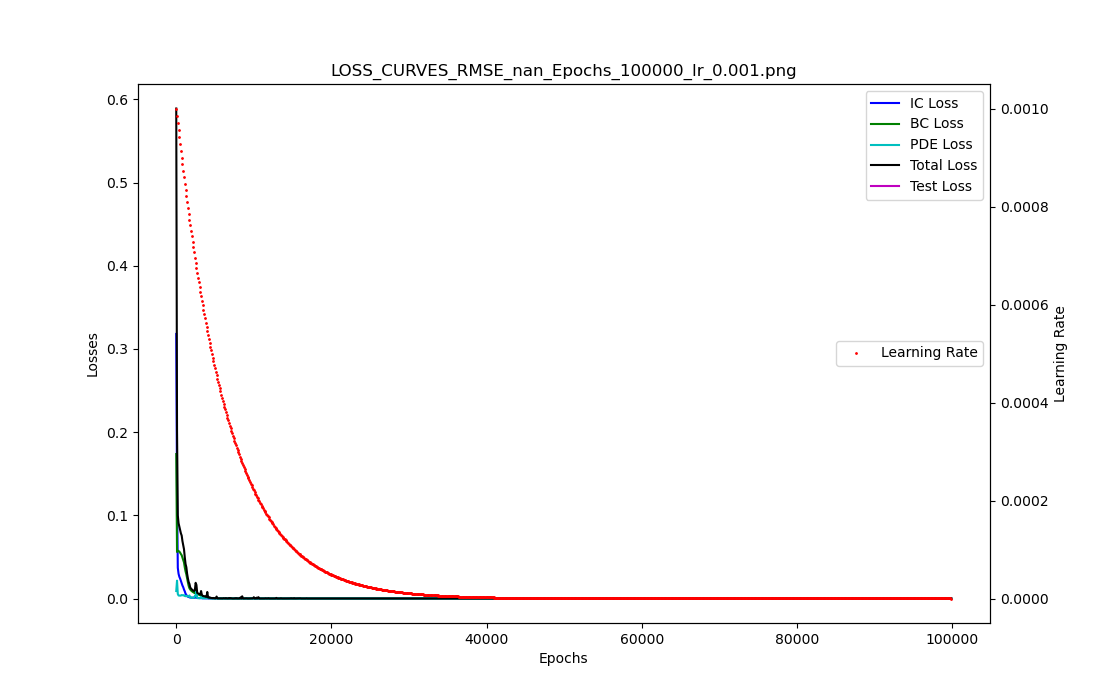

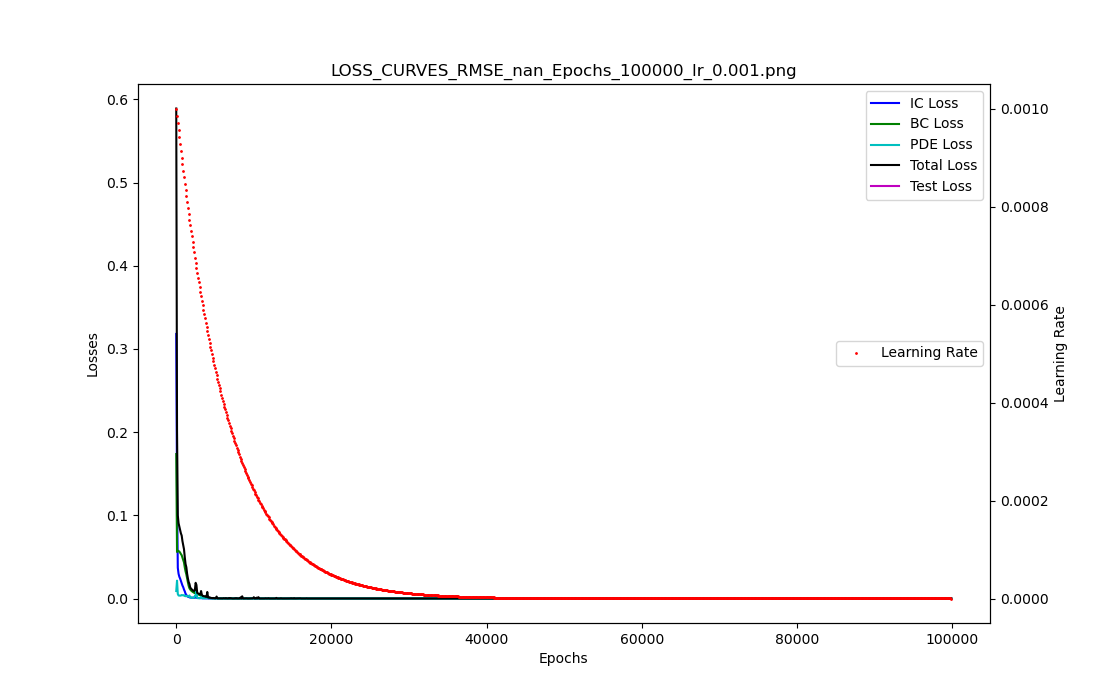

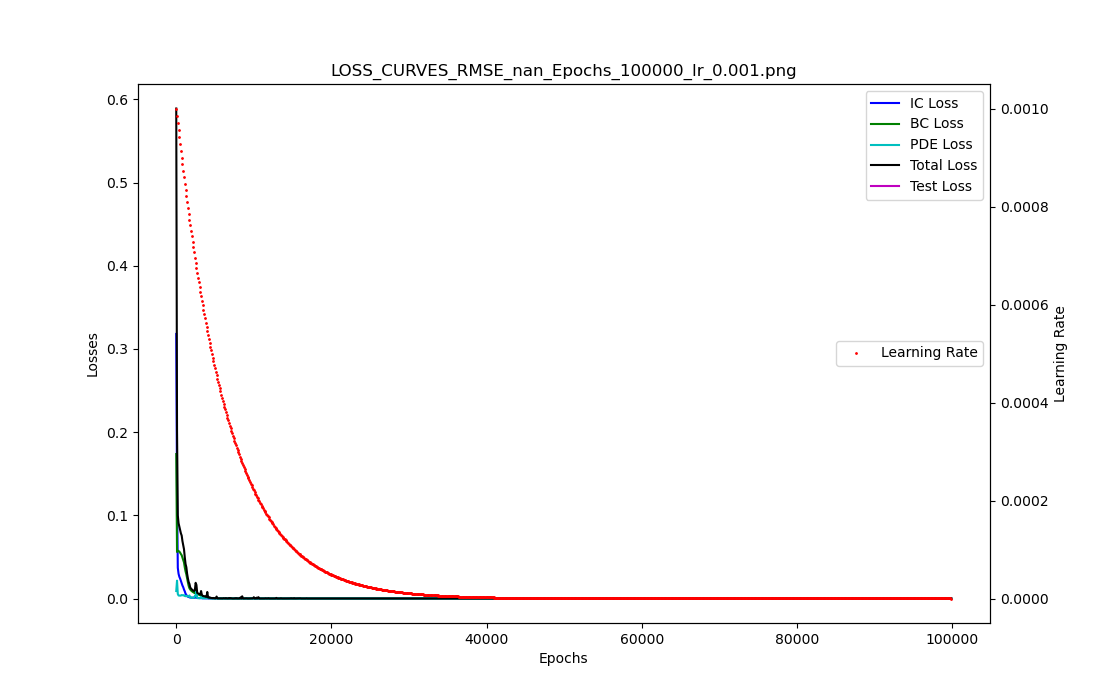

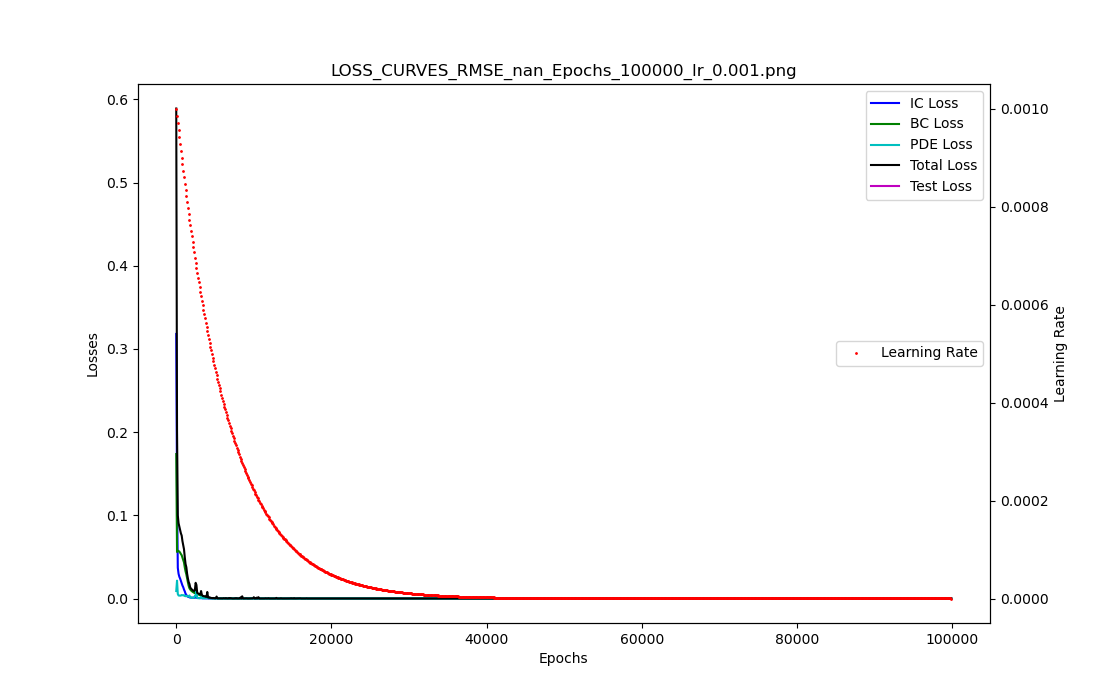

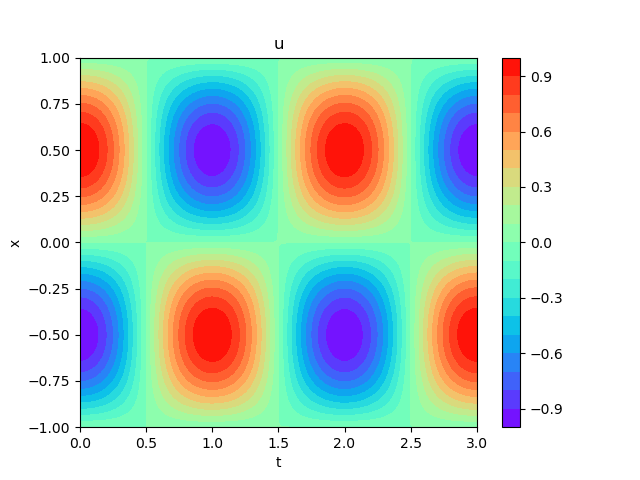

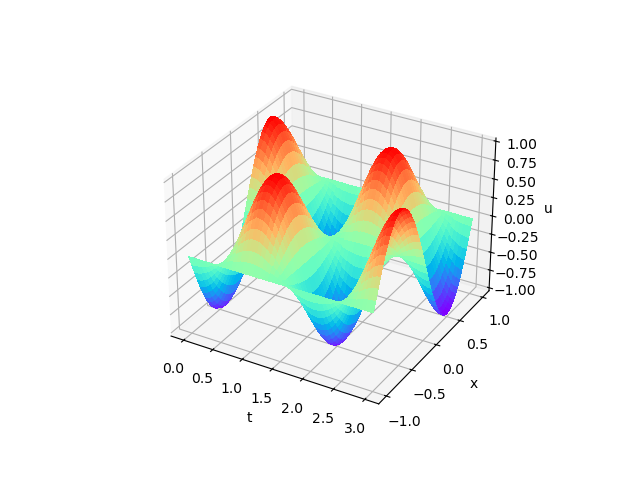

In [60]:
plot3D(x,t,u_NN_2D)

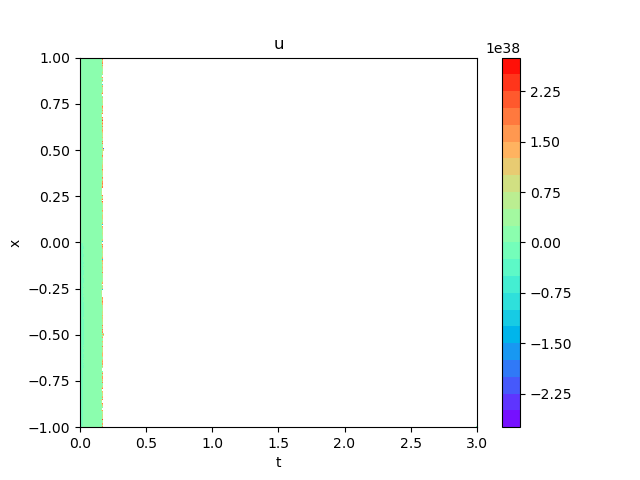

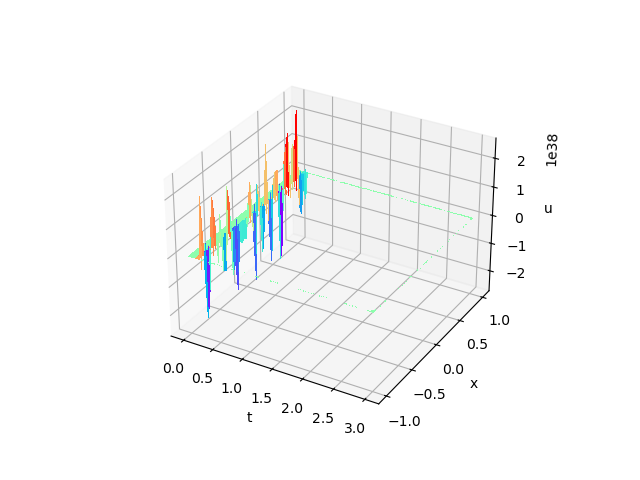

In [ ]:
plot3D(x,t,u_fem_2D)

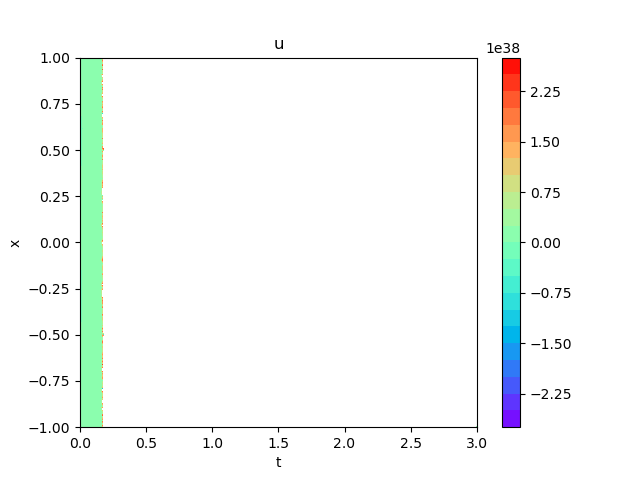

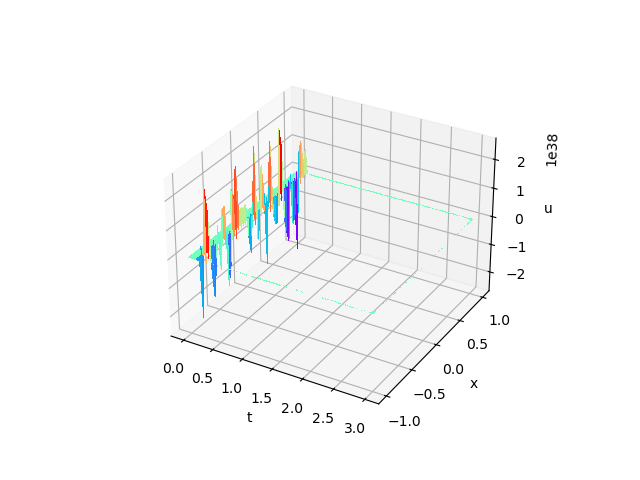

In [63]:
plot3D(x,t,(u_NN_2D - u_fem_2D.cpu())) #Error

In [64]:
RMSE = torch.sqrt(torch.tensor(Test_Loss[-1])) # Calculate RMSE from the last test_loss
file_name_result = "Result_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".png"

last_U_NN = u_NN_2D[:,-1].unsqueeze(1) #Extracting the last U values at t=0.48

fig, ax1 = plt.subplots(figsize=(11, 7), dpi= 100)
ax2 = ax1.twinx()

ax1.plot(x, u_plot.cpu().numpy(), "g",label="Initial Condition at t=0")
ax1.plot(x, u_final.cpu().numpy(), "r",label="FDM at t=0.48", )
ax1.plot(x, last_U_NN.detach().cpu().numpy(), "bo",label="PINN Predict at t=0.48", markersize=1.5)
ax1.legend()
plt.title(file_name_result)
plt.savefig("./Wave/"+file_name_result)

In [65]:
RMSE = torch.sqrt(torch.tensor(Test_Loss[-1])) # Calculate RMSE from the last test_loss
#Saving the model

file_name_model = "Result_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".pth"
torch.save(PINN, "./Wave/"+file_name_model)